<a href="https://colab.research.google.com/github/rishabhCMS/stripe/blob/main/Stripe_Churn_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Data Cleaning

1. convert object type date-time column to date-time
2. convert cents to USD

In [4]:
df = pd.read_csv("/content/drive/MyDrive/Stripe Takehome/takehome_ds_written.csv")

In [5]:
df.head()

,Unnamed: 0,merchant,time,amount_usd_in_cents
0,1,faa029c6b0,2034-06-17 23:34:14,6349
1,2,ed7a7d91aa,2034-12-27 00:40:38,3854
2,3,5608f200cf,2034-04-30 01:29:42,789
3,4,15b1a0d61e,2034-09-16 01:06:23,4452
4,5,4770051790,2034-07-22 16:21:42,20203


In [15]:
df['time'] = pd.to_datetime(df['time'])
df['amt_usd'] = df['amount_usd_in_cents']/100
import datetime as dt
NOW = dt.datetime(2035,1,1)

# Aggregating DataFrame on to generate RFM table

In [17]:
rfmTable = df.groupby('merchant').agg({'time': lambda x: (NOW - x.max()).days, 'merchant': lambda x: len(x), 'amt_usd': lambda x: x.sum()})

In [18]:
rfmTable['time'] = rfmTable['time'].astype(int)
rfmTable.rename(columns={'time': 'recency', 
                         'merchant': 'frequency', 
                         'amt_usd': 'monetary_value'}, inplace=True)
rfmTable.reset_index(inplace=True)
rfmTable.head()

# VIzaulizing RFM 

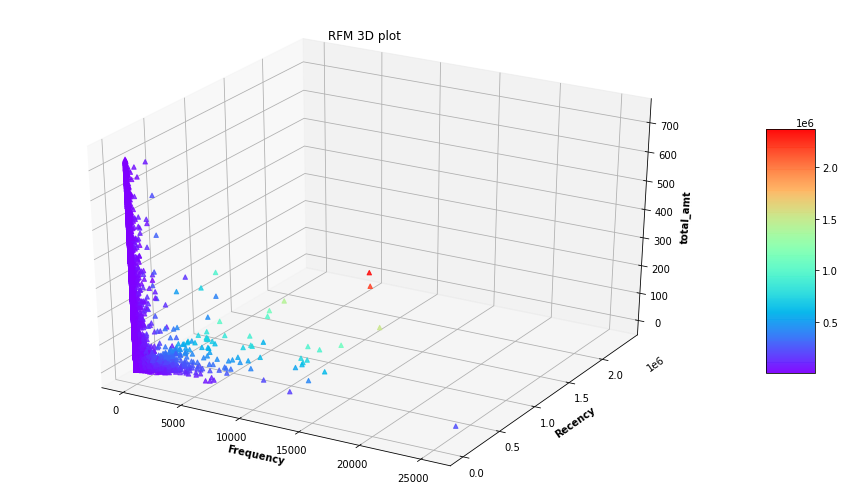

In [22]:
# Import libraries
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
 
 
# Creating dataset
x = rfmTable.frequency
z = rfmTable.recency
y = rfmTable.monetary_value
 
# Creating figure
fig = plt.figure(figsize = (16, 9))
ax = plt.axes(projection ="3d")
   
# Add x, y gridlines
ax.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.3,
        alpha = 0.2)
 
 
# Creating color map
my_cmap = plt.get_cmap('rainbow')
 
# Creating plot
sctt = ax.scatter3D(x, y, z,
                    alpha = 0.8,
                    c = (x + y + z),
                    cmap = my_cmap,
                    marker ='^')
 
plt.title("RFM 3D plot")
ax.set_xlabel('Frequency', fontweight ='bold')
ax.set_ylabel('Recency', fontweight ='bold')
ax.set_zlabel('total_amt', fontweight ='bold')
fig.colorbar(sctt, ax = ax, shrink = 0.5, aspect = 5)
 
# show plot
plt.show()

** We want to target a few things**


1.   Our best customers are the one with low recency, high frequency, and high total amount




# Starting Simple with 5 group Segmentation



In [23]:
quantiles = rfmTable.quantile(q=[0.20, 0.40, 0.60, 0.80])
quantiles = quantiles.to_dict()
quantiles


In [25]:

def r_class(x,p,quart_dict):
  '''
    Summary: this function returns the recency class of a customer
    based on where it's recency value lies in the distribution
  
    Parameters:
    x : series in the column 
    p : recency or monetary_value or frequency
    d : quantile dictionary 
  
    Returns:
    int: class of the customer
  '''


  if x <= quart_dict[p][0.20]:
      return 5
  elif x <= quart_dict[p][0.40]:
      return 4
  elif x <= quart_dict[p][0.60]: 
      return 3
  elif x <= quart_dict[p][0.80]:
      return 2
  else:return 1
    

def fm_class(x,p,quart_dict):
  '''
    Summary: this function returns the recency class of a customer
    based on where it's monetary value  or the freqency lies in the distribution
  
    low percentile would correspond to low freqency and low monetory value

    Parameters:
    x : series in the column 
    p : recency or monetary_value or frequency
    d : quantile dictionary 
  
    Returns:
    int: class of the customer
  '''
  if x <= quart_dict[p][0.20]:
      return 1
  elif x <= quart_dict[p][0.40]:
      return 2
  elif x <= quart_dict[p][0.60]: 
      return 3
  elif x <= quart_dict[p][0.80]:
      return 4
  else:return 5



In [26]:
rfmTable['R_Quartile'] = rfmTable['recency'].apply(r_class, args=('recency',quantiles,))
rfmTable['F_Quartile'] = rfmTable['frequency'].apply(fm_class, args=('frequency',quantiles,))
rfmTable['M_Quartile'] = rfmTable['monetary_value'].apply(fm_class, args=('monetary_value',quantiles,))
rfmTable['RFMClass'] = rfmTable.R_Quartile.map(str) + rfmTable.F_Quartile.map(str) + rfmTable.M_Quartile.map(str)

# Your Good Customer is one with 

1.   Low Recency, high R_quartile
2.   high monetary_value or high M_quartile
3.   High Frequency value or high F_quartile



# Part II

sometimes a merchant may stop processing with Stripe, which we call churn. We are interested in identifying and predicting churn. Please 
  b)  

1.   come up with a concrete definition for churn
2.   identify merchants that have already churned in the dataset

3. build a model to predict which active merchants are most likely to churn in the near future.



(array([4444., 1521.,  863.,  614.,  464.,  451.,  396.,  344.,  320.,
         246.,  261.,  236.,  225.,  207.,  249.,  174.,  255.,  183.,
         163.,  173.,  130.,  144.,  140.,  135.,  110.,  106.,  136.,
          99.,  103.,  111.,  119.,   80.,   92.,   88.,   84.,   93.,
          82.,   79.,   68.,   87.,   63.,   81.,   55.,   59.,   50.,
          47.,   47.,   30.,   24.,   20.]),
 array([  0.  ,  14.56,  29.12,  43.68,  58.24,  72.8 ,  87.36, 101.92,
        116.48, 131.04, 145.6 , 160.16, 174.72, 189.28, 203.84, 218.4 ,
        232.96, 247.52, 262.08, 276.64, 291.2 , 305.76, 320.32, 334.88,
        349.44, 364.  , 378.56, 393.12, 407.68, 422.24, 436.8 , 451.36,
        465.92, 480.48, 495.04, 509.6 , 524.16, 538.72, 553.28, 567.84,
        582.4 , 596.96, 611.52, 626.08, 640.64, 655.2 , 669.76, 684.32,
        698.88, 713.44, 728.  ]),
 <a list of 50 Patch objects>)

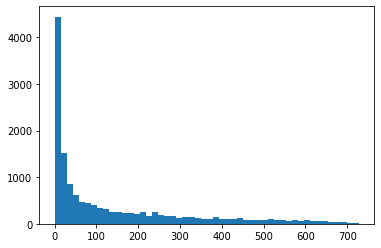

In [27]:
plt.hist(rfmTable['recency'], bins=50)

In [28]:
begin = df.time.min()
end= df.time.max()
print(begin, end)

2033-01-01 09:38:32 2034-12-31 07:59:40


# Criteria for Churn Rate

churn  rate = # of customers lost in the quarter/ # of customers you had at the beginning of the quarter

a quarter = 3 month intervals in a calender year


In [29]:
from datetime import date
from dateutil.relativedelta import relativedelta

#define quarters
begin = df.time.min()
quarter_list = ['q1', 'q2', 'q3', 'q4', 'q5', 'q6', 'q7', 'q8']
quarter_dict = {}
q1 = begin + relativedelta(months=+3)
q2 = q1 + relativedelta(months=+3)
q3 = q2 + relativedelta(months=+3)
q4 = q3 + relativedelta(months=+3)
q5 = q4 + relativedelta(months=+3)
q6 = q5 + relativedelta(months=+3)
q7 = q6 + relativedelta(months=+3)
q8 = q7 + relativedelta(months=+3)

for i in range(1,9):
  key = 'q{}'.format(i)
  value = begin + relativedelta(months=+3)
  quarter_dict[key] = value
  begin = value

quarter_dict

{'q1': Timestamp('2033-04-01 09:38:32'),
 'q2': Timestamp('2033-07-01 09:38:32'),
 'q3': Timestamp('2033-10-01 09:38:32'),
 'q4': Timestamp('2034-01-01 09:38:32'),
 'q5': Timestamp('2034-04-01 09:38:32'),
 'q6': Timestamp('2034-07-01 09:38:32'),
 'q7': Timestamp('2034-10-01 09:38:32'),
 'q8': Timestamp('2035-01-01 09:38:32')}

In [30]:
df_quart = df.groupby(by='merchant').agg({'time': lambda x: (x.max())})
df_quart.reset_index(inplace=True)

In [31]:
def calc_churn(qA, qB, df):
  '''
  This fuction returns the churn in Quarter A by comapring with Quarter B

  args:
  qA: Quarter A timedate
  qB: Quarter B timedate

  df: dataframe grouped by merchant aggregated on the last transaction date

  return: churn value

  '''



  num_of_total_customers_qA = (df[df['time'] <= q1]).shape[0]
  num_customers_lost_qA = (num_of_total_customers_qA - (df_quart[(df_quart['time'] > qA) & (df_quart['time'] <=qB)]).shape[0])
  churn = num_customers_lost_qA / num_of_total_customers_qA
  return churn

In [32]:
# calc_churn(q3,q4,df_quart)

-2.1402714932126696

In [33]:
quarter_tuple_list = list(zip(quarter_list, quarter_list[1:] + quarter_list[:1]))

In [34]:
# quarter_tuple_list

[('q1', 'q2'),
 ('q2', 'q3'),
 ('q3', 'q4'),
 ('q4', 'q5'),
 ('q5', 'q6'),
 ('q6', 'q7'),
 ('q7', 'q8'),
 ('q8', 'q1')]

In [35]:
churn_dict = {}
for i, j in quarter_tuple_list:
  # churn_dict = {}
  # print(i,j)
  churn_dict[i] = calc_churn(quarter_dict[i],quarter_dict[j], df_quart)

print(churn_dict)

{'q1': -1.0135746606334841, 'q2': -1.4389140271493213, 'q3': -2.1402714932126696, 'q4': -2.8733031674208145, 'q5': -4.932126696832579, 'q6': -7.108597285067873, 'q7': -37.42986425339367, 'q8': 1.0}


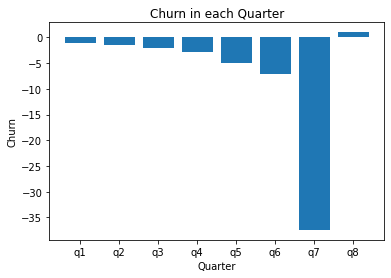

In [36]:
import matplotlib.pyplot as plt

D = churn_dict
plt.bar(*zip(*D.items()))
plt.title("Churn in each Quarter")
plt.xlabel("Quarter")
plt.ylabel("Churn")
plt.show()

**The Above plot shows that you are basically loosing customers each quarter**

Merchants who have already churned

In [37]:
#according to my churn period (3 months)
# i want to know which merchants stopped transacting at the ned of each quarter
rfmTable.head()


,merchant,recency,frequency,monetary_value,R_Quartile,F_Quartile,M_Quartile,RFMClass
0,0002b63b92,594,1,33.79,1,1,1,111
1,0002d07bba,16,4,892.78,4,2,3,423
2,00057d4302,514,28,295.21,1,4,2,142
3,000bcff341,509,1,78.26,1,1,1,111
4,000ddbf0ca,577,1,102.99,1,1,1,111


# Churn Modelling

Text(0, 0.5, 'Counts')

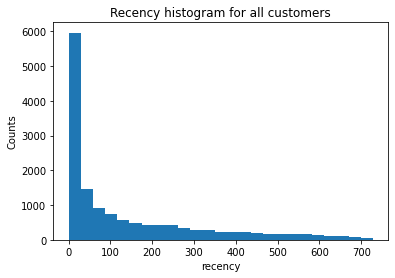

In [60]:
plt.hist(rfmTable.recency, bins=25)
plt.title("Recency histogram for all customers")
plt.xlabel("recency")
plt.ylabel('Counts')

In [63]:
rfmTable.recency.mean()

136.96160546303395

In [39]:
#asssumption
# a merchant that fails to transact 1 months(30 days) after their last transaction is considered as churned
# 30 days are chosen on the basis of a monthly subscription, if a subscription is not renewed the customer it is tagged as churned


In [40]:
#churned customers
rfmTable[rfmTable.recency>30]

,merchant,recency,frequency,monetary_value,R_Quartile,F_Quartile,M_Quartile,RFMClass
0,0002b63b92,594,1,33.79,1,1,1,111
2,00057d4302,514,28,295.21,1,4,2,142
3,000bcff341,509,1,78.26,1,1,1,111
4,000ddbf0ca,577,1,102.99,1,1,1,111
7,001f7b7a4f,304,1,64.44,1,1,1,111
...,...,...,...,...,...,...,...,...
14343,ffc5a319bb,398,2,7220.68,1,1,4,114
14346,ffd3e45675,703,5,726.26,1,2,2,122
14347,ffe1f6b51a,315,53,2816.16,1,4,3,143
14348,ffe26b900d,40,81,9591.13,3,5,4,354


# Modelling

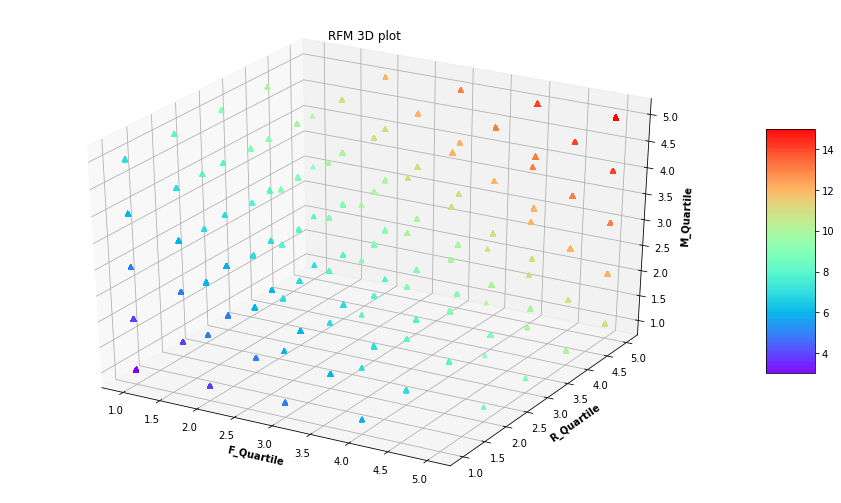

In [62]:
# Import libraries
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
 
 
# Creating dataset
x = rfmTable.F_Quartile
z = rfmTable.R_Quartile
y = rfmTable.M_Quartile
 
# Creating figure
fig = plt.figure(figsize = (16, 9))
ax = plt.axes(projection ="3d")
   
# Add x, y gridlines
ax.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.3,
        alpha = 0.2)
 
 
# Creating color map
my_cmap = plt.get_cmap('rainbow')
 
# Creating plot
sctt = ax.scatter3D(x, y, z,
                    alpha = 0.8,
                    c = (x + y + z),
                    cmap = my_cmap,
                    marker ='^')
 
plt.title("RFM 3D plot")
ax.set_xlabel('F_Quartile', fontweight ='bold')
ax.set_ylabel('R_Quartile', fontweight ='bold')
ax.set_zlabel('M_Quartile', fontweight ='bold')
fig.colorbar(sctt, ax = ax, shrink = 0.5, aspect = 5)
 
# show plot
plt.show()

# A very simplistic model from the above RFM plot would be apply hard selection cuts on the R,F,M quartiles to observe that the redd-ish region are our most loyal customers and likely to stay with us, While High F, M may point to a good customer but since they have low recency we may already lost them

# References

1. https://www.geeksforgeeks.org/3d-scatter-plotting-in-python-using-matplotlib/
2. https://towardsdatascience.com/find-your-best-customers-with-customer-segmentation-in-python-61d602f9eee6
3. https://clevertap.com/blog/rfm-analysis/